In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
from pathlib import Path
from matplotlib import pyplot as plt

In [4]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel


In [5]:
import diffusers
diffusers.__version__ 

'0.32.2'

In [6]:
from omegaconf import OmegaConf
from txt2img import load_model_from_config

/home/nadavg/anaconda3/envs/qdiff/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [7]:
if False:
    config = OmegaConf.load(f'{Path.home()}/q-diffusion/configs/stable-diffusion/v1-inference.yaml')
    model = load_model_from_config(config, "/fastdata/users/nadavg/sd/qdiff/sd-v1-4.ckpt")
    unet1_4 = model.model.diffusion_model

In [21]:
pipe = StableDiffusionPipeline.from_pretrained("SG161222/Realistic_Vision_V4.0_noVAE")
#unet = pipe.net

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
unet_org = pipe.unet
#unet = pipe.unet

In [10]:
from src.utils.torch_utils import add_full_name_to_module
from torch import nn


In [11]:
from qdiff.quant_block import QuantResBlockHF15,BaseQuantBlock
from diffusers.models.resnet import ResnetBlock2D

In [13]:
i =0 
rsb = unet.down_blocks[i].resnets[1]
type(rsb)

diffusers.models.resnet.ResnetBlock2D

In [15]:
rsb_q = QuantResBlockHF15(rsb)

In [18]:
import torch
x = torch.rand(torch.Size([2, 320, 64, 64]))
temb= torch.rand(torch.Size([2, 1280]))

In [20]:
e = rsb(x,temb) - rsb_q(x,temb)

In [17]:
type(unet.down_blocks[3])

diffusers.models.unets.unet_2d_blocks.DownBlock2D

In [12]:
for i in range(4):
    for j in range(2):
        unet.down_blocks[i].resnets[j] = QuantResBlockHF15(unet.down_blocks[i].resnets[j])

In [13]:
from src.utils.torch_utils import  save_input_hook, register_forword_hook

In [14]:
for i in range(4):
    for j in range(2):
        register_forword_hook(unet.down_blocks[i].resnets[j], save_input_hook)

In [32]:
i,j = 3,0
in1 = unet.down_blocks[i].resnets[j].saved_inputs[0]
in1 = [x.detach().cpu() for x in in1]
len(in1)

2

In [33]:
rbq1  = unet.down_blocks[i].resnets[j].cpu()
rb1 = unet_org.down_blocks[i].resnets[j].cpu()
type(rbq1),type(rb1)

(qdiff.quant_block.QuantResBlockHF15, diffusers.models.resnet.ResnetBlock2D)

In [34]:
torch.sum(torch.abs(rbq1(*in1) - rb1(*in1)))

tensor(0., grad_fn=<SumBackward0>)

In [65]:
rb1 = unet_org.down_blocks[3].resnets[0].cpu()

In [72]:
rb1.dropout
rb1.upsample,rb1.downsample
rb1.norm1,rb1.nonlinearity,rb1.upsample,rb1.downsample,rb1.conv1
rb1.time_emb_proj,rb1.time_embedding_norm,rb1.skip_time_act
rb1.norm2,rb1.nonlinearity,rb1.dropout,rb1.conv2
rb1.conv_shortcut,rb1.output_scale_factor

(None, 1.0)

In [128]:
rb1.skip_time_act

False

In [129]:
[i.shape for i in in1]

[torch.Size([2, 320, 64, 64]), torch.Size([2, 1280])]

In [119]:
rbq1.in_layers
#rbq1.emb_layers
#rbq1.out_layers
#rbq1.skip_connection

Sequential(
  (0): GroupNorm(32, 320, eps=1e-05, affine=True)
  (1): SiLU()
  (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [97]:
_=rbq1(*in1)

In [ ]:
e = rbq1(*in1) - rb1(*in1)

tensor([[[[ 8.3802e-02,  2.9833e-02,  1.5967e-01,  ...,  1.7389e-01,
            3.4918e-02,  1.0245e-01],
          [-3.3602e-02,  1.3191e-01,  6.0835e-02,  ...,  1.5393e-01,
           -6.5274e-03, -5.8522e-02],
          [ 1.0848e-05,  2.2181e-01,  1.1115e-01,  ...,  1.1770e-01,
            1.8791e-01,  1.1727e-01],
          ...,
          [ 6.1479e-02,  6.1308e-02,  1.1342e-01,  ...,  1.1320e-01,
            5.9542e-02,  4.8445e-02],
          [ 5.1605e-02,  5.5502e-02,  9.3227e-02,  ...,  2.1485e-01,
            5.4969e-02,  7.7139e-02],
          [-1.1392e-01,  2.0985e-02,  3.9220e-02,  ..., -1.7848e-03,
            8.0072e-03, -2.5976e-02]],

         [[-7.2308e-01, -1.1479e+00, -1.0222e+00,  ..., -1.1307e+00,
           -1.1973e+00, -8.5800e-01],
          [-1.2766e+00, -1.6780e+00, -1.6730e+00,  ..., -1.6963e+00,
           -1.6924e+00, -1.2454e+00],
          [-1.2248e+00, -1.7501e+00, -1.6999e+00,  ..., -1.6659e+00,
           -1.6504e+00, -1.1696e+00],
          ...,
     

In [17]:
([unet.down_blocks[i].resnets[1].use_in_shortcut for i in range(4)])

[False, False, False, False]

In [ ]:
type(unet.down_blocks[3].resnets[0]),type(unet.down_blocks[1].downsamplers[0])

(diffusers.models.resnet.ResnetBlock2D,
 diffusers.models.downsampling.Downsample2D)

In [36]:
str(type(unet.mid_block))

"<class 'diffusers.models.unets.unet_2d_blocks.UNetMidBlock2DCrossAttn'>"

In [20]:
type(unet.up_blocks[0])

diffusers.models.unets.unet_2d_blocks.UpBlock2D

In [21]:
unet.conv_norm_out

GroupNorm(32, 320, eps=1e-05, affine=True)

In [32]:
from collections import OrderedDict


In [11]:
add_full_name_to_module(unet)
add_full_name_to_module(unet1_4)

In [37]:
unet1_5_dict = OrderedDict()
for module in unet.modules():
    if 'CrossAtt' in str(type(module)):
        print(module.full_name)
    #if isinstance(module, (CrossAttnDownBlock2D , AttnDownBlock2D, UNetMidBlock2DSimpleCrossAttn , nn.BatchNorm2d)):
    #     unet1_5_dict[module.full_name]=type(module)

down_blocks.0
down_blocks.1
down_blocks.2
up_blocks.1
up_blocks.2
up_blocks.3
mid_block


In [51]:
[type(db) for db in unet.down_blocks]#[0]

[diffusers.models.unets.unet_2d_blocks.CrossAttnDownBlock2D,
 diffusers.models.unets.unet_2d_blocks.CrossAttnDownBlock2D,
 diffusers.models.unets.unet_2d_blocks.CrossAttnDownBlock2D,
 diffusers.models.unets.unet_2d_blocks.DownBlock2D]

In [53]:
for i in range(3):
    print(f'rsnets: {len(unet.down_blocks[i].resnets)}, attn: {len(unet.down_blocks[i].attentions)} ds: {len(unet.down_blocks[i].downsamplers)}')
    

rsnets: 2, attn: 2 ds: 1
rsnets: 2, attn: 2 ds: 1
rsnets: 2, attn: 2 ds: 1


In [28]:
unet.down_blocks[0]

CrossAttnDownBlock2D(
  (attentions): ModuleList(
    (0-1): 2 x Transformer2DModel(
      (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
      (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
      (transformer_blocks): ModuleList(
        (0): BasicTransformerBlock(
          (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          (attn1): Attention(
            (to_q): Linear(in_features=320, out_features=320, bias=False)
            (to_k): Linear(in_features=320, out_features=320, bias=False)
            (to_v): Linear(in_features=320, out_features=320, bias=False)
            (to_out): ModuleList(
              (0): Linear(in_features=320, out_features=320, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          (attn2): Attention(
            (to_q): Linear(in_features=320, out_features=320, bias=False)
            (to_k): Linear(in_

In [81]:
i=0
type(unet.down_blocks[i].resnets[1]),type(unet.down_blocks[i].attentions[1]),type(unet.down_blocks[i].downsamplers[0])

(diffusers.models.resnet.ResnetBlock2D,
 diffusers.models.transformers.transformer_2d.Transformer2DModel,
 diffusers.models.downsampling.Downsample2D)

In [94]:
type(unet.down_blocks[i].attentions[1].transformer_blocks[0])
unet.down_blocks[i].attentions[1].transformer_blocks[0].norm_type

'layer_norm'

In [85]:
# get class file path
import inspect
unet.down_blocks[i].attentions[1].__module__

'diffusers.models.transformers.transformer_2d'

In [43]:
unet.down_blocks[0].resnets[0].downsample#norm1#nonlinearity#time_emb_proj

AttributeError: 'QuantResBlockHF15' object has no attribute 'downsample'

In [56]:
[type(unet.mid_block)]#[0]

[diffusers.models.unets.unet_2d_blocks.UNetMidBlock2DCrossAttn]

In [52]:
[type(db) for db in unet.up_blocks]#[0]

[diffusers.models.unets.unet_2d_blocks.UpBlock2D,
 diffusers.models.unets.unet_2d_blocks.CrossAttnUpBlock2D,
 diffusers.models.unets.unet_2d_blocks.CrossAttnUpBlock2D,
 diffusers.models.unets.unet_2d_blocks.CrossAttnUpBlock2D]

In [45]:
len(unet.down_blocks[2].resnets) , len(unet.down_blocks[2].attentions)

(2, 2)

In [ ]:
mapping = {
    'time_embed.0':'time_embedding.linear_1',
    'time_embed.2':'time_embedding.linear_2',
    
}

In [13]:
unet.config.keys()


odict_keys(['sample_size', 'in_channels', 'out_channels', 'center_input_sample', 'flip_sin_to_cos', 'freq_shift', 'down_block_types', 'mid_block_type', 'up_block_types', 'only_cross_attention', 'block_out_channels', 'layers_per_block', 'downsample_padding', 'mid_block_scale_factor', 'dropout', 'act_fn', 'norm_num_groups', 'norm_eps', 'cross_attention_dim', 'transformer_layers_per_block', 'reverse_transformer_layers_per_block', 'encoder_hid_dim', 'encoder_hid_dim_type', 'attention_head_dim', 'num_attention_heads', 'dual_cross_attention', 'use_linear_projection', 'class_embed_type', 'addition_embed_type', 'addition_time_embed_dim', 'num_class_embeds', 'upcast_attention', 'resnet_time_scale_shift', 'resnet_skip_time_act', 'resnet_out_scale_factor', 'time_embedding_type', 'time_embedding_dim', 'time_embedding_act_fn', 'timestep_post_act', 'time_cond_proj_dim', 'conv_in_kernel', 'conv_out_kernel', 'projection_class_embeddings_input_dim', 'attention_type', 'class_embeddings_concat', 'mid_blo

In [16]:
unet1_4.config = unet.config
pipe.unet = unet1_4


In [15]:
import torch
torch.cuda.is_available()

True

In [16]:
_=pipe.to("cuda")

In [17]:
type(pipe.unet)

diffusers.models.unets.unet_2d_condition.UNet2DConditionModel

In [18]:
pipe._execution_device

device(type='cuda', index=0)

In [19]:
I = pipe("a puppy wearing a hat",num_inference_steps=20).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

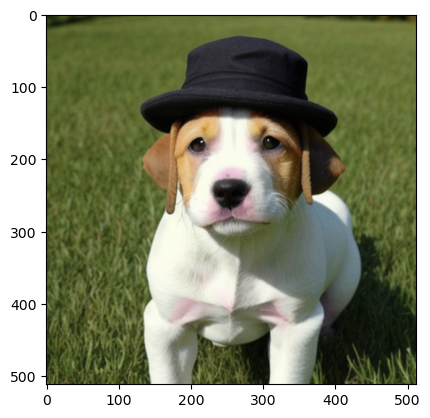

In [20]:
plt.imshow(I)

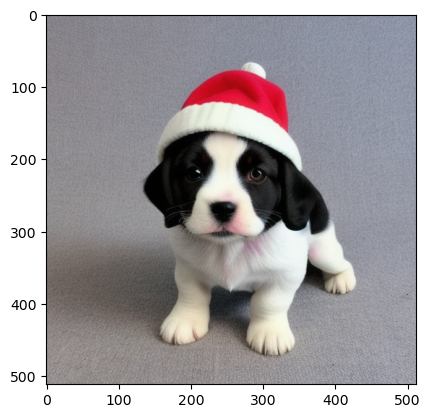

In [ ]:
plt.imshow(I)